# Control probing for untrained model

The following notebook contains probing control tests performed for randomly initialized untrained model.

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-untrained'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}

def get_probe_dataset(data):
    strings = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = np.random.randint(1, len(seq))
        seq_str = decode(seq[:i])
        # seq_str = decode(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_str[i])
        engine = C4Engine(seq_str)

        # if seq_str[:i+1] in strings:
        #     continue
        # strings.add(seq_str[:i+1])
        if seq_str in strings:
            continue
        strings.add(seq_str)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16261, 384]),
 torch.Size([16261, 42]),
 torch.Size([16261, 7]),
 torch.Size([16261, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1873, 384]),
 torch.Size([1873, 42]),
 torch.Size([1873, 7]),
 torch.Size([1873, 6]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [15]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.0633
Epoch   1: 1.0006
Epoch   2: 0.9567
Epoch   3: 0.9262
Epoch   4: 0.9044
Epoch   5: 0.8875
Epoch   6: 0.8741
Epoch   7: 0.8624
Epoch   8: 0.8526
Epoch   9: 0.8432
Epoch  10: 0.8349
Epoch  11: 0.8273
Epoch  12: 0.8200
Epoch  13: 0.8132
Epoch  14: 0.8069
Epoch  15: 0.8008
Epoch  16: 0.7951
Epoch  17: 0.7897
Epoch  18: 0.7847
Epoch  19: 0.7796
Epoch  20: 0.7749
Epoch  21: 0.7703
Epoch  22: 0.7660
Epoch  23: 0.7619
Epoch  24: 0.7579
Epoch  25: 0.7539
Epoch  26: 0.7502
Epoch  27: 0.7467
Epoch  28: 0.7431
Epoch  29: 0.7398
Epoch  30: 0.7366
Epoch  31: 0.7336
Epoch  32: 0.7304
Epoch  33: 0.7275
Epoch  34: 0.7247
Epoch  35: 0.7219
Epoch  36: 0.7192
Epoch  37: 0.7166
Epoch  38: 0.7140
Epoch  39: 0.7115
Epoch  40: 0.7091
Epoch  41: 0.7067
Epoch  42: 0.7045
Epoch  43: 0.7022
Epoch  44: 0.7001
Epoch  45: 0.6981
Epoch  46: 0.6959
Epoch  47: 0.6939
Epoch  48: 0.6920
Epoch  49: 0.6900
Epoch  50: 0.6882
Epoch  51: 0.6863
Epoch  52: 0.6845
Epoch  53: 0.6828
Epoch  54: 0.6811
Epoch  55:

Predict number of pieces in each column

In [16]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 1.9188
Epoch   1: 1.8689
Epoch   2: 1.8321
Epoch   3: 1.8036
Epoch   4: 1.7799
Epoch   5: 1.7593
Epoch   6: 1.7407
Epoch   7: 1.7236
Epoch   8: 1.7076
Epoch   9: 1.6924
Epoch  10: 1.6782
Epoch  11: 1.6647
Epoch  12: 1.6520
Epoch  13: 1.6396
Epoch  14: 1.6280
Epoch  15: 1.6166
Epoch  16: 1.6060
Epoch  17: 1.5956
Epoch  18: 1.5857
Epoch  19: 1.5763
Epoch  20: 1.5670
Epoch  21: 1.5583
Epoch  22: 1.5498
Epoch  23: 1.5416
Epoch  24: 1.5336
Epoch  25: 1.5259
Epoch  26: 1.5183
Epoch  27: 1.5111
Epoch  28: 1.5042
Epoch  29: 1.4974
Epoch  30: 1.4907
Epoch  31: 1.4843
Epoch  32: 1.4780
Epoch  33: 1.4719
Epoch  34: 1.4660
Epoch  35: 1.4601
Epoch  36: 1.4546
Epoch  37: 1.4490
Epoch  38: 1.4437
Epoch  39: 1.4383
Epoch  40: 1.4333
Epoch  41: 1.4284
Epoch  42: 1.4234
Epoch  43: 1.4186
Epoch  44: 1.4138
Epoch  45: 1.4094
Epoch  46: 1.4047
Epoch  47: 1.4002
Epoch  48: 1.3959
Epoch  49: 1.3917
Epoch  50: 1.3875
Epoch  51: 1.3834
Epoch  52: 1.3794
Epoch  53: 1.3753
Epoch  54: 1.3716
Epoch  55:

Predict number of pieces in each row

In [17]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.0377
Epoch   1: 1.9556
Epoch   2: 1.8897
Epoch   3: 1.8363
Epoch   4: 1.7924
Epoch   5: 1.7556
Epoch   6: 1.7237
Epoch   7: 1.6955
Epoch   8: 1.6700
Epoch   9: 1.6464
Epoch  10: 1.6245
Epoch  11: 1.6040
Epoch  12: 1.5847
Epoch  13: 1.5662
Epoch  14: 1.5487
Epoch  15: 1.5322
Epoch  16: 1.5163
Epoch  17: 1.5010
Epoch  18: 1.4865
Epoch  19: 1.4725
Epoch  20: 1.4591
Epoch  21: 1.4463
Epoch  22: 1.4340
Epoch  23: 1.4219
Epoch  24: 1.4105
Epoch  25: 1.3994
Epoch  26: 1.3886
Epoch  27: 1.3782
Epoch  28: 1.3683
Epoch  29: 1.3586
Epoch  30: 1.3491
Epoch  31: 1.3402
Epoch  32: 1.3315
Epoch  33: 1.3229
Epoch  34: 1.3145
Epoch  35: 1.3067
Epoch  36: 1.2989
Epoch  37: 1.2914
Epoch  38: 1.2840
Epoch  39: 1.2769
Epoch  40: 1.2701
Epoch  41: 1.2634
Epoch  42: 1.2569
Epoch  43: 1.2506
Epoch  44: 1.2443
Epoch  45: 1.2385
Epoch  46: 1.2326
Epoch  47: 1.2269
Epoch  48: 1.2215
Epoch  49: 1.2159
Epoch  50: 1.2107
Epoch  51: 1.2056
Epoch  52: 1.2005
Epoch  53: 1.1957
Epoch  54: 1.1910
Epoch  55:

### Test linear probes

In [18]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [19]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [20]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.7814, 0.7919, 0.7845, 0.7454, 0.8219, 0.8629, 0.9067, 0.7482, 0.7498,
        0.7347, 0.6964, 0.7712, 0.8198, 0.8752, 0.7146, 0.7161, 0.6930, 0.6498,
        0.7231, 0.7612, 0.8338, 0.6882, 0.6671, 0.6642, 0.6433, 0.6987, 0.7254,
        0.8021, 0.6512, 0.6423, 0.6339, 0.5952, 0.6465, 0.6725, 0.7508, 0.6098,
        0.6061, 0.6232, 0.6281, 0.6257, 0.6256, 0.6538], device='cuda:0')

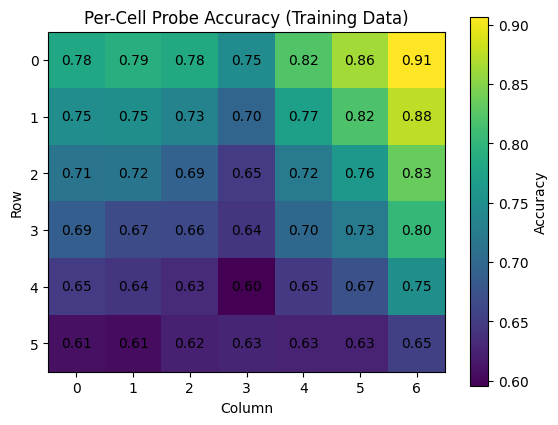

In [21]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [22]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.7977, 0.7934, 0.7891, 0.7592, 0.8265, 0.8601, 0.8948, 0.7453, 0.7507,
        0.7314, 0.6887, 0.7726, 0.8190, 0.8703, 0.7015, 0.7053, 0.6941, 0.6599,
        0.7368, 0.7571, 0.8201, 0.6839, 0.6690, 0.6765, 0.6498, 0.6914, 0.7357,
        0.7993, 0.6684, 0.6471, 0.6471, 0.5921, 0.6588, 0.6695, 0.7453, 0.5937,
        0.6231, 0.6209, 0.6375, 0.5948, 0.6316, 0.6466], device='cuda:0')

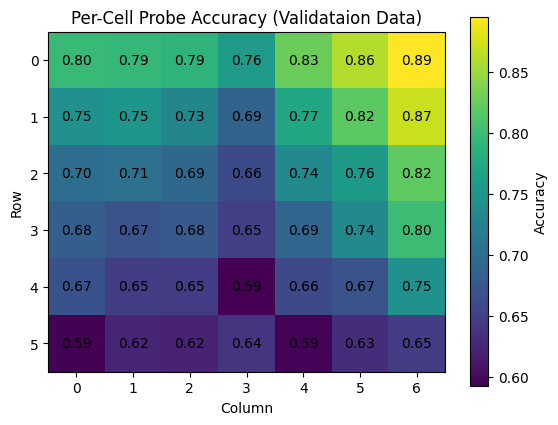

In [23]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [24]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.6608, 0.6674, 0.6685, 0.6568, 0.6355, 0.6263, 0.6711],
       device='cuda:0')

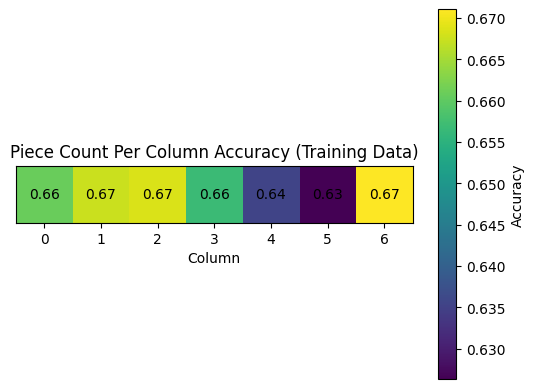

In [25]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [26]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.6647, 0.6711, 0.6594, 0.6327, 0.6444, 0.6241, 0.6813],
       device='cuda:0')

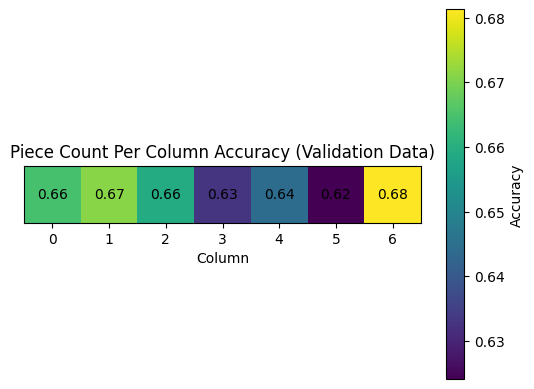

In [27]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [28]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.6570, 0.6110, 0.6335, 0.6327, 0.6184, 0.6133], device='cuda:0')

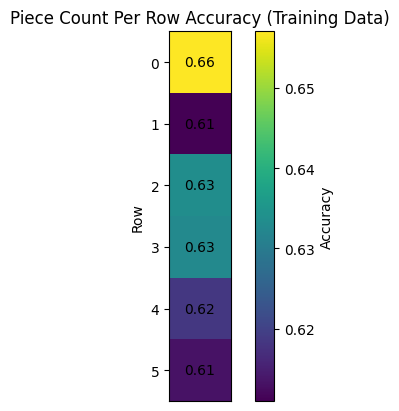

In [29]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [30]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.6610, 0.6177, 0.6498, 0.6353, 0.6060, 0.5814], device='cuda:0')

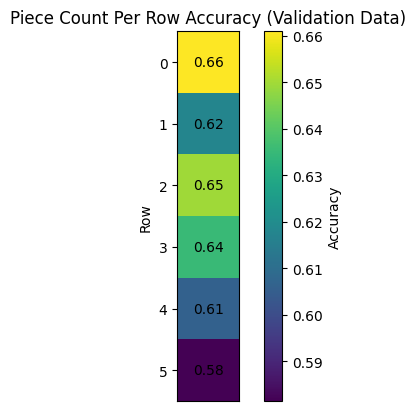

In [31]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)